In [1]:
#This notebook will try to detect the gender information from ML model. Sklearn.
import pandas as pd
import json
import re
import unicodedata

In [133]:
count = 0
type = set()
cols = ["gender","raw_text"]
df = pd.read_csv("./(V1.8)all_products_data_set.csv", usecols=cols)
for row in range(df.shape[0]):
    gender_words = df.loc[row]['gender']
    if gender_words == 'women\xa0':
        df.loc[row, 'gender'] = gender_words.replace(u'\xa0', u'')
        count+=1
    if gender_words == 'men\xa0':
        df.loc[row, 'gender'] = gender_words.replace(u'\xa0', u'')
        count += 1
print(count)
df.shape

0


(28426, 2)

In [134]:
df = df[pd.notnull(df['raw_text'])]
df = df[pd.notnull(df['gender'])]
df.shape

(25985, 2)

In [135]:
col = ["gender", "raw_text"]
#modify names of columns
df.columns = ["Gender", "Product_Description"]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25985 entries, 0 to 28425
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Gender               25985 non-null  object
 1   Product_Description  25985 non-null  object
dtypes: object(2)
memory usage: 609.0+ KB


In [136]:
#drop the unknown/unset/broken
index_broken = df[((df.Gender == "broken") | (df.Gender == "unknown") | (df.Gender == "unset") |(df.Gender == 'women\xa0') | (df.Gender == 'men\xa0'))].index
df = df.drop(index_broken)
df.shape

(25347, 2)

In [137]:
df['gender_id'] = df['Gender'].factorize()[0]
from io import StringIO
category_id_df = df[['Gender', 'gender_id']].drop_duplicates().sort_values('gender_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['gender_id', 'Gender']].values)
df.head()

,Gender,Product_Description,gender_id
0,women,The Sol. These bottoms are made from 100% recy...,0
1,women,These Bitsy Roger bottoms are crafted from shi...,0
2,women,Nothing says high and mighty like the Frenchi ...,0
3,women,The Desi Bottoms is made from 100% recycled ma...,0
4,women,Meet Court. Your new summer BFF. These high wa...,0


In [27]:
#df = df.query('(Gender == "women")').sample(n=2000)

In [138]:
#modify the bias
temp_df = df.query('(Gender == "men")').sample(n=3000)
index_men = df[(df.Gender == "men")].index
df = df.drop(index_men)

df = df.append(temp_df)

temp_df = df.query('(Gender == "women")').sample(n=3000)
index_women = df[(df.Gender == "women")].index

df = df.drop(index_women)
df = df.append(temp_df)


/var/folders/r2/xt2ymfnd7nz2khk687zqlrpr0000gn/T/ipykernel_41047/2673869804.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp_df)
/var/folders/r2/xt2ymfnd7nz2khk687zqlrpr0000gn/T/ipykernel_41047/2673869804.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp_df)


In [141]:
df = df.sort_index()

In [142]:
df.head()

,Gender,Product_Description,gender_id
3,women,The Desi Bottoms is made from 100% recycled ma...,0
4,women,Meet Court. Your new summer BFF. These high wa...,0
5,women,A retro-inspired sculptural silhouette makes t...,0
8,na,"A gentle, wild crafted dandelion and elderflow...",1
9,women,Hello Jess! Made from 100% recycled materials....,0


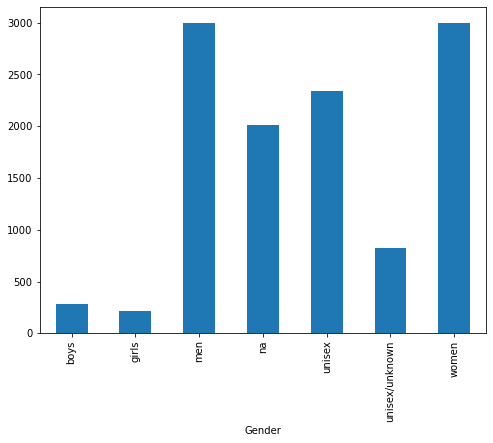

In [143]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Gender').Product_Description.count().plot.bar(ylim=0)
plt.show()

#### need to take the number of 'men' and 'women' to around 3000, otherwise it will cause the bias of the data.

In [96]:
df.columns

Index(['Gender', 'Product_Description', 'gender_id'], dtype='object')

In [144]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Product_Description).toarray()
labels = df.gender_id
features.shape

(11671, 32333)

In [145]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Gender, gender_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == gender_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Gender))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

/Users/luis/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'boys':
  . Most correlated unigrams:
       . boy
       . boys
  . Most correlated bigrams:
       . rvca boys
       . shirt boys


/Users/luis/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'girls':
  . Most correlated unigrams:
       . kids
       . girls
  . Most correlated bigrams:
       . supply kids
       . years age


/Users/luis/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'men':
  . Most correlated unigrams:
       . men
       . shirt
  . Most correlated bigrams:
       . short sleeve
       . shirt black


/Users/luis/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'na':
  . Most correlated unigrams:
       . includes
       . sheet
  . Most correlated bigrams:
       . includes sheet
       . sheet black


/Users/luis/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'unisex':
  . Most correlated unigrams:
       . backpack
       . laptop
  . Most correlated bigrams:
       . larger kids
       . 10 12


/Users/luis/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'unisex/unknown':
  . Most correlated unigrams:
       . lens
       . frame
  . Most correlated bigrams:
       . uv protection
       . 100 uv
# 'women':
  . Most correlated unigrams:
       . bust
       . neckline
  . Most correlated bigrams:
       . sky fit
       . fit guide


/Users/luis/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [147]:
#

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Product_Description'], df['Gender'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [160]:
print(clf.predict(count_vect.transform(["This blue v neck jacket is sweet and beautiful and cute"])))

['women']


In [109]:
print(clf.predict(count_vect.transform(["This is male jacket and so cool."])))

['men']


In [148]:
print(clf.predict(count_vect.transform(["Baby strawberry girls' t-shirt is so perfect for age under 12."])))

['women']


In [112]:
print(clf.predict(count_vect.transform(["Boys' big toy."])))

['boys']


In [149]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/Users/luis/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/luis/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

In [161]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.641426
LogisticRegression        0.626687
MultinomialNB             0.606036
RandomForestClassifier    0.375976
Name: accuracy, dtype: float64

In [152]:
#make sure the index is continuous
df = df.reset_index()

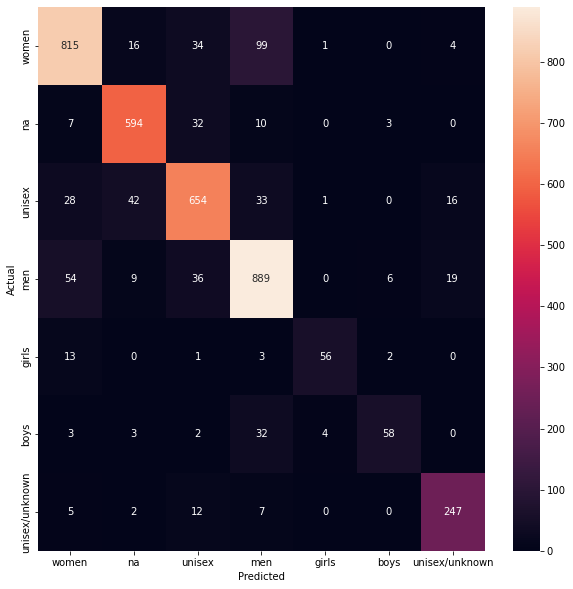

In [154]:
import seaborn as sns
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Gender.values, yticklabels=category_id_df.Gender.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [156]:
from IPython.display import display
for predicted in category_id_df.gender_id:
  for actual in category_id_df.gender_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Gender', 'Product_Description']])
      print('')

'unisex' predicted as 'women' : 28 examples.


,Gender,Product_Description
10403,unisex,This unisex tee fits like a well-loved favorit...
487,unisex,Classic collared button down shirt with an ove...
3376,unisex,Cultured Pearls Length - 18.25; each pearl mea...
4604,unisex,The 1990s were an incredible time for hip hop ...
4911,unisex,Zippered wallet / wristlet with a slip pocket ...
146,unisex,Airy short sleeve shirt with a mandarin collar...
4525,unisex,"Comfortable in any setting, the Kensington add..."
11637,unisex,"Finally, a fitness tee that’s built to outlast..."
7721,unisex,Replacing our fabric and Velcro Strappy Strap ...
294,unisex,Hemp and organic cotton corduroy shorts with 4...



'men' predicted as 'women' : 54 examples.


,Gender,Product_Description
9203,men,The Checkerboard Classic Slip-On features stur...
8986,men,"First introduced in 1977, the Vans #98-now kno..."
1509,men,/ HOW IT FITS - Ease over body fit. Accommodat...
1060,men,This black denim jacket will take you from spr...
4088,men,This breathable linen long sleeve button-up sh...
2529,men,1329291-001 Product DNA Loose: Fuller cut for ...
1984,men,M860G12 Most people don’t make a routine out o...
5927,men,RELAXED FIT ELASTIC WAIST NYLON SHORT. 100% NY...
4311,men,Modern design has gone full circle as Ray-Ban ...
4128,men,LINE is best-selling MILA crew neck is crafted...



'girls' predicted as 'women' : 13 examples.


,Gender,Product_Description
3318,girls,Calling all fairy princesses! We have the dres...
10496,girls,Z Supply kids Amalfi dip dye dress Dip dye is ...
8660,girls,The Sunday Strut short is a relaxed rise short...
11470,girls,Additional Information: This teeny two-piece s...
11135,girls,When the days get longer and the sun gets stro...
7290,girls,"Durable, breathable, and oh so cute, the Last ..."
6264,girls,Rompers are in and she will be too with this t...
10528,girls,Brunette the Label kids leopard top This favou...
10600,girls,Smash + Tess kids mini sweetheart romper What ...
10694,girls,Brunette the Label kids redhead tee 100% cotton



'women' predicted as 'na' : 16 examples.


,Gender,Product_Description
11387,women,Additional Information: PERFECTLY GLOSSY LIP C...
2343,women,NS40180-50043 No matter how fast or far youre ...
11545,women,"Additional Information: So, we totally get sce..."
528,women,"Made from 100% linen in soft earthy hues, crea..."
1856,women,Keep your special B’ver super soft and supple ...
10729,women,So Luxury Himalayan cleansing bar Só Luxury i...
11246,women,The unisex Harlow Robe is a premium robe that ...
3998,women,Multi color
3933,women,Your post workout treat for tired and sore mus...
1685,women,Take a vacation from dry lips with our delicio...



'unisex' predicted as 'na' : 42 examples.


,Gender,Product_Description
9176,unisex,Not Real Rails but Look Like It
1559,unisex,These non-toxic soy candles are hand poured in...
1818,unisex,Shea good-bye to dry skin and Shea hello to da...
8518,unisex,Pixar
7968,unisex,SANTA CRUZ Shaped Toxic Hand 9.7 Cruiser Compl...
1861,unisex,COOL DOWN ALOE VERA SPRAY. We like to prevent ...
845,unisex,We are swooning over how cute these baby onesi...
663,unisex,An easy to fall in love with statement piece. ...
2648,unisex,1308932-002 Large main compartment with cinch ...
11147,unisex,Additional Information: Our daily hydrating co...



'women' predicted as 'unisex' : 34 examples.


,Gender,Product_Description
1403,women,The Beaded collection is the perfect line of f...
1568,women,"Morse Code Jewelry represents a subtle, secret..."
11577,women,Stop the glare and shield your face from the s...
2405,women,125058.789.10.00 Lightweight Multifunctional n...
9613,women,Large Backpack 33.00 x 35.00 x 13.00 cm Featur...
9620,women,Messenger Bag 36 x 25 x 8.5 cm
10547,women,Okanagan Lifestyle bonfire hoodie A fan favour...
3283,women,Fabric - 100% Viscose <!--.tb_button .tb_butto...
598,women,"A hardworking, multitasking clay treatment for..."
4254,women,Zip wallet. Details: Interior holds total of 1...



'na' predicted as 'unisex' : 32 examples.


,Gender,Product_Description
7778,na,"Affordable, easy skating mini cruzer with supe..."
1495,na,"It’s just like an umbrella, only better. Stay ..."
7542,na,TAKE ANY OUTDOOR ADVENTURE TO THE NEXT LEVEL W...
10788,na,Enjoy our limited-edition Self Love Sticker Pa...
597,na,Ripple is a fresh beach scent with blended not...
9912,na,Durable and fade-resistant silicone with reinf...
9954,na,The Origins Collection draws inspiration from ...
8659,na,MOB Griptape Green
9109,na,Some of us like to go as au naturel as possibl...
4230,na,Happy hour is even happier with our 64 oz Grow...



'men' predicted as 'unisex' : 36 examples.


,Gender,Product_Description
1570,men,"As the name suggests, this classic surf-style ..."
7607,men,"Clean, simple, and slouchy style for cold-morn..."
2767,men,"Fabric: 95% Bamboo, 5% Lycra"
4668,men,Eye catching without filter and remarkably fun...
1654,men,Our Cocoon Surf Poncho is made from our luxuri...
9495,men,Limited run collaboration capsule with Flora d...
4386,men,Organize your tech accessories without tangles...
9045,men,Features Water based inks Global Organic Texti...
4252,men,A Herschel Supply signature for cold weather d...
7536,men,Features Water based inks Global Organic Texti...



'unisex/unknown' predicted as 'unisex' : 12 examples.


,Gender,Product_Description
4447,unisex/unknown,Details Reworking the proportions of the class...
9286,unisex/unknown,Frogskins® Mix takes a fresh approach to the b...
4654,unisex/unknown,Details: The Ray-Ban ® RB3447 sunglasses are t...
4959,unisex/unknown,"Details Influenced by sport and pop-culture, F..."
4448,unisex/unknown,Details Reworking the proportions of the class...
6577,unisex/unknown,Classic meets modern with Clubmaster Marble. T...
4900,unisex/unknown,A modernized and minimal update on classic sty...
8807,unisex/unknown,Storming in with ultra-thick sides and a front...
4437,unisex/unknown,Details Hugo Boss B0665/S sunglasses feature a...
2734,unisex/unknown,Grey Kaaniao Coast Matte Black white blue



'women' predicted as 'men' : 99 examples.


,Gender,Product_Description
5292,women,Flat-top sunhat featuring a classic back band ...
2284,women,1110521-BBLC Engineered with an EVA midsole fo...
7806,women,Fresh style with the power of GORE-TEX and lig...
2511,women,"24085-1776 Clean, casual technical fleece card..."
1597,women,Hand polished polycarbonate frames ● Premium s...
...,...,...
1774,women,The Seaside is made for aquatic adventures. It...
1957,women,DH4072-501 ENERGIZED FOR MILES. Running is you...
7389,women,The TM2 is widely known as the most versatile ...
979,women,Cotton shirt with all over fractal print. Navy...



'na' predicted as 'men' : 10 examples.


,Gender,Product_Description
4188,na,We are very excited to showcase the art of the...
7823,na,The Vans Verse Snowboard Boots are a big mount...
9223,na,The Juvie boot is designed for young riders se...
4775,na,Description: Ready to go from the mountain cab...
639,na,This simple and beautiful c anvas pouch is han...
9048,na,BURTON Channel Plug Mountain Logo
5606,na,THE RVCA SHORT SLEEVE RASHGUARD COMBINES NYLON...
7264,na,RDS Multi Tool Camo
8939,na,RDS OG Apron
6810,na,SIZE ADAPTABLE COMFORT AND CONTROL. Built with...



'unisex' predicted as 'men' : 33 examples.


,Gender,Product_Description
9553,unisex,This warm merino wool knit toque from Duer is ...
4315,unisex,WARRIOR PRINT: Stance has teamed up with self ...
1085,unisex,PANTHER - BLACK Colour: Black Adjustable Adjus...
1766,unisex,Be in charge when you don the Mayor. Influenti...
4226,unisex,Our Uncommon Solids are the staple to every so...
2543,unisex,CDNKELSNAPBACK-BLK DESCRIPTION Material: 83% A...
4191,unisex,Charcoal. Unisex. Bamboo and Organic cotton. C...
10094,unisex,Cotton canvas Woven label
9813,unisex,Modern tapered fit 30 inch inseam Unisex: does...
4523,unisex,"A sculpture inspired by sharp angles, this dou..."



'boys' predicted as 'men' : 32 examples.


,Gender,Product_Description
5973,boys,"Delivering comfort, unique style, and a full d..."
6706,boys,The Frickin Cross Shred Static hybrid shorts l...
7260,boys,Garb your grom in latest youth t-shirts and ap...
7265,boys,RDS OG Puffy Flexfit Hat Toddler Black/Red
5385,boys,The Surf Revival Boxed Tee is an great boy is ...
9336,boys,Vans The V76 Skinny in Overdye Black is an 11....
915,boys,A classic driver cap shaped from a soft poly-w...
7028,boys,An every day pullover he will reach for again ...
6682,boys,Supreme comfort and totally rad style come tog...
8596,boys,They will be taking a walk on the wild side in...



'unisex' predicted as 'unisex/unknown' : 16 examples.


,Gender,Product_Description
4428,unisex,Details Marc Jacobs sunglasses truly embody a ...
4713,unisex,Story: A device of measure and special purpose...
2466,unisex,7530426-104 Prevent the uncomfortable feeling ...
5318,unisex,Square frame oversized sunglasses in an acetat...
4687,unisex,Demand attention and command respect with Dale...
4890,unisex,Product Description: A daily driver for the ro...
5233,unisex,Story: A device of measure and special purpose...
4894,unisex,Product Description: A daily driver for the ro...
4497,unisex,Details This prescription-ready addition to th...
4891,unisex,Product Description: The Swingarm is lightweig...



'men' predicted as 'unisex/unknown' : 19 examples.


,Gender,Product_Description
4606,men,﻿Details: ﻿ The Hawaiian word hookipa means ho...
4941,men,Details Sleek architecture and sculptural reli...
4639,men,Details: Ray-Ban Aviator Gradient sunglasses e...
4296,men,"As edgy as it is smooth, Jack is pure Ray-Ban ..."
4578,men,﻿Product Description: The same comfortable and...
5006,men,Details: Go back to where it all began with Ra...
4375,men,Inspired by streetwear culture and global infl...
4518,men,Details The XL edition offers a standard size ...
4400,men,Details Be Wilder—at least that’s how we say i...
4873,men,Frame Details Model : 0EA4058 Shape : Rectangl...


In [157]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

/Users/luis/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'boys':
  . Top unigrams:
       . boys
       . boy
  . Top bigrams:
       . shirt youth
       . dex kids
# 'girls':
  . Top unigrams:
       . girls
       . kids
  . Top bigrams:
       . hatley kids
       . features girls
# 'men':
  . Top unigrams:
       . men
       . shirt
  . Top bigrams:
       . cotton colour
       . size large
# 'na':
  . Top unigrams:
       . skateboard
       . towel
  . Top bigrams:
       . sheet black
       . rds lanyard
# 'unisex':
  . Top unigrams:
       . unisex
       . model
  . Top bigrams:
       . trucker hats
       . skateboard grip
# 'unisex/unknown':
  . Top unigrams:
       . sunglasses
       . frame
  . Top bigrams:
       . black matte
       . 100 uv
# 'women':
  . Top unigrams:
       . women
       . strap
  . Top bigrams:
       . high rise
       . okanagan lifestyle


In [159]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Gender'].unique()))

                precision    recall  f1-score   support

         women       0.88      0.84      0.86       969
            na       0.89      0.92      0.91       646
        unisex       0.85      0.84      0.85       774
         girls       0.83      0.88      0.85      1013
           men       0.90      0.75      0.82        75
          boys       0.84      0.57      0.68       102
unisex/unknown       0.86      0.90      0.88       273

      accuracy                           0.86      3852
     macro avg       0.87      0.81      0.83      3852
  weighted avg       0.86      0.86      0.86      3852



In [169]:
texts = ["This blue v neck jacket is sweet and beautiful and cute.",
         "This is male jacket and so cool",
         "Baby strawberry girls' t-shirt is so perfect for age under 12.",
         "A little baby's funny toy.",
         "This sunglasses will be good for male and female",
         "Big boy would like this jean",
         "The Fuseli One Piece is a summer staple. Crafted with a front gold zip detail and high leg line for a modest, yet contemporary look. The Fuseli has a full-body power mesh for body sculpting confidence, and wide shoulder straps for extra comfort and support. Model is wearing an Australian size 18+",
         "Easy and relaxed pullover with a crew neck and long sleeves. Made of a light and cool hemp blend. Details: 55% hemp, 45% organic cotton Made in California, USA Cody is wearing a size M About the brand: From roots of simplicity and sustainability, Robert Jungmann created Jungmaven in a sleepy surf town in Central America where the natural rhythms of life seamlessly evolved into the brands mission. With the wisdom that the Earth deserves our love and care, came a passion for hemp fabrics. Jungmaven believes fashion is a form of activism and by creating beautiful, high quality hemp clothing we can choose to use our dollars to demand change.",
         "Dresses."]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"This blue v neck jacket is sweet and beautiful and cute."
  - Predicted as: 'women'

"This is male jacket and so cool"
  - Predicted as: 'men'

"Baby strawberry girls' t-shirt is so perfect for age under 12."
  - Predicted as: 'girls'

"A little baby's funny toy."
  - Predicted as: 'unisex'

"This sunglasses will be good for male and female"
  - Predicted as: 'unisex/unknown'

"Big boy would like this jean"
  - Predicted as: 'boys'

"The Fuseli One Piece is a summer staple. Crafted with a front gold zip detail and high leg line for a modest, yet contemporary look. The Fuseli has a full-body power mesh for body sculpting confidence, and wide shoulder straps for extra comfort and support. Model is wearing an Australian size 18+"
  - Predicted as: 'women'

"Easy and relaxed pullover with a crew neck and long sleeves. Made of a light and cool hemp blend. Details: 55% hemp, 45% organic cotton Made in California, USA Cody is wearing a size M About the brand: From roots of simplicity and sus

In [172]:
import pickle
#save model
with open('gender_detector_model.pkl', 'wb') as f:
    pickle.dump(model,f)

#load model
with open("gender_detector_model.pkl", 'rb') as f:
    loaded_gender_detect_model = pickle.load(f)

    

"Style Deals - When temps start to rise, slip into this supremely cute babydoll dress outfitted with a vibrant floral print! Its warm-weather details include short sleeves, round neckline, and a slightly shorter length. Team this with your sandals, straw hat, and of course, your oversized sunnies. "
  - Predicted as: 'women'

